# Intrduction


**What?** Implementation of a Bayesian optimiser from scratch



# Intro on Bayesian optimisation


- Bayesian Optimization provides a technique based on Bayes Theorem to direct an optimisation search.
- It works by building a probabilistic model of the objective function, called the **surrogate function**, that is then searched efficiently with an **acquisition function** before candidate samples are chosen for evaluation on the real objective function.
- In this way instead of blinding chosing candidate (this could be also brute force), the method pprovide an improved guess.
- It is is often used to tune the hyperparameters as a more "efficient" alternative to random and grid search. 



# Gaussian process and Bayesian optimisation


- Sometimes the two terms are used together, interchangable and it is difficult to see what is what.
- **Optimisation** = We'd like to either minimise or maximise a funciton.
- **Bayesian-theorem** = Is what drives the optimisation, meaning it gets to decide the next point to evaluate which offer the greatest improvement.
- **Gaussian process** = is used as a surrogate model in the optimisation loop. We need a surrogate to approximate the function otherwise it would be too expensive to compute point-by-point.  Further a GP process can give a reliable estimate of their own uncertainty. Pratically, it provides the standard deviation which is then used in the Bayesian theorem to compute the probability of improvement.



# Import modules

In [1]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20
mpl.rcParams['figure.dpi']= 300

# Action plan


- Define a test function to play with
- Create a surrogate function
- Create an acquisition function



# Test function


- We will use a multimodal problem with five peaks augmented by adding Gaussian noise with a mean of zero  and a standard deviation of 0.1. 
- This will make the function challenging to optimize.



In [2]:
def objective(x, mean = 0, std = 0.1):
    """Objective function
    
    mean and std are used to constract the normal curve
    """
    noise = normal(loc = mean, scale = std)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

In [3]:
X = arange(0, 1, 0.005)
# No nise
y = [objective(x, 0, 0) for x in X]
# Add noise
ynoise = [objective(x) for x in X]


- Maximisation problem = fins the max.
- As we are in the lucky position to know the objective function we'll find where the max is.
- We'll use this to see if the Bayesian optimisation algorithm can locate it. Better to say, how close it gets to it.



In [4]:
# Find best result -> maximisation
ix = argmax(y)
X_opt = X[ix]
y_opt = y[ix]
print('Optimum: x=%.3f, y=%.3f' % (X_opt, y_opt))

Optimum: x=0.900, y=0.810


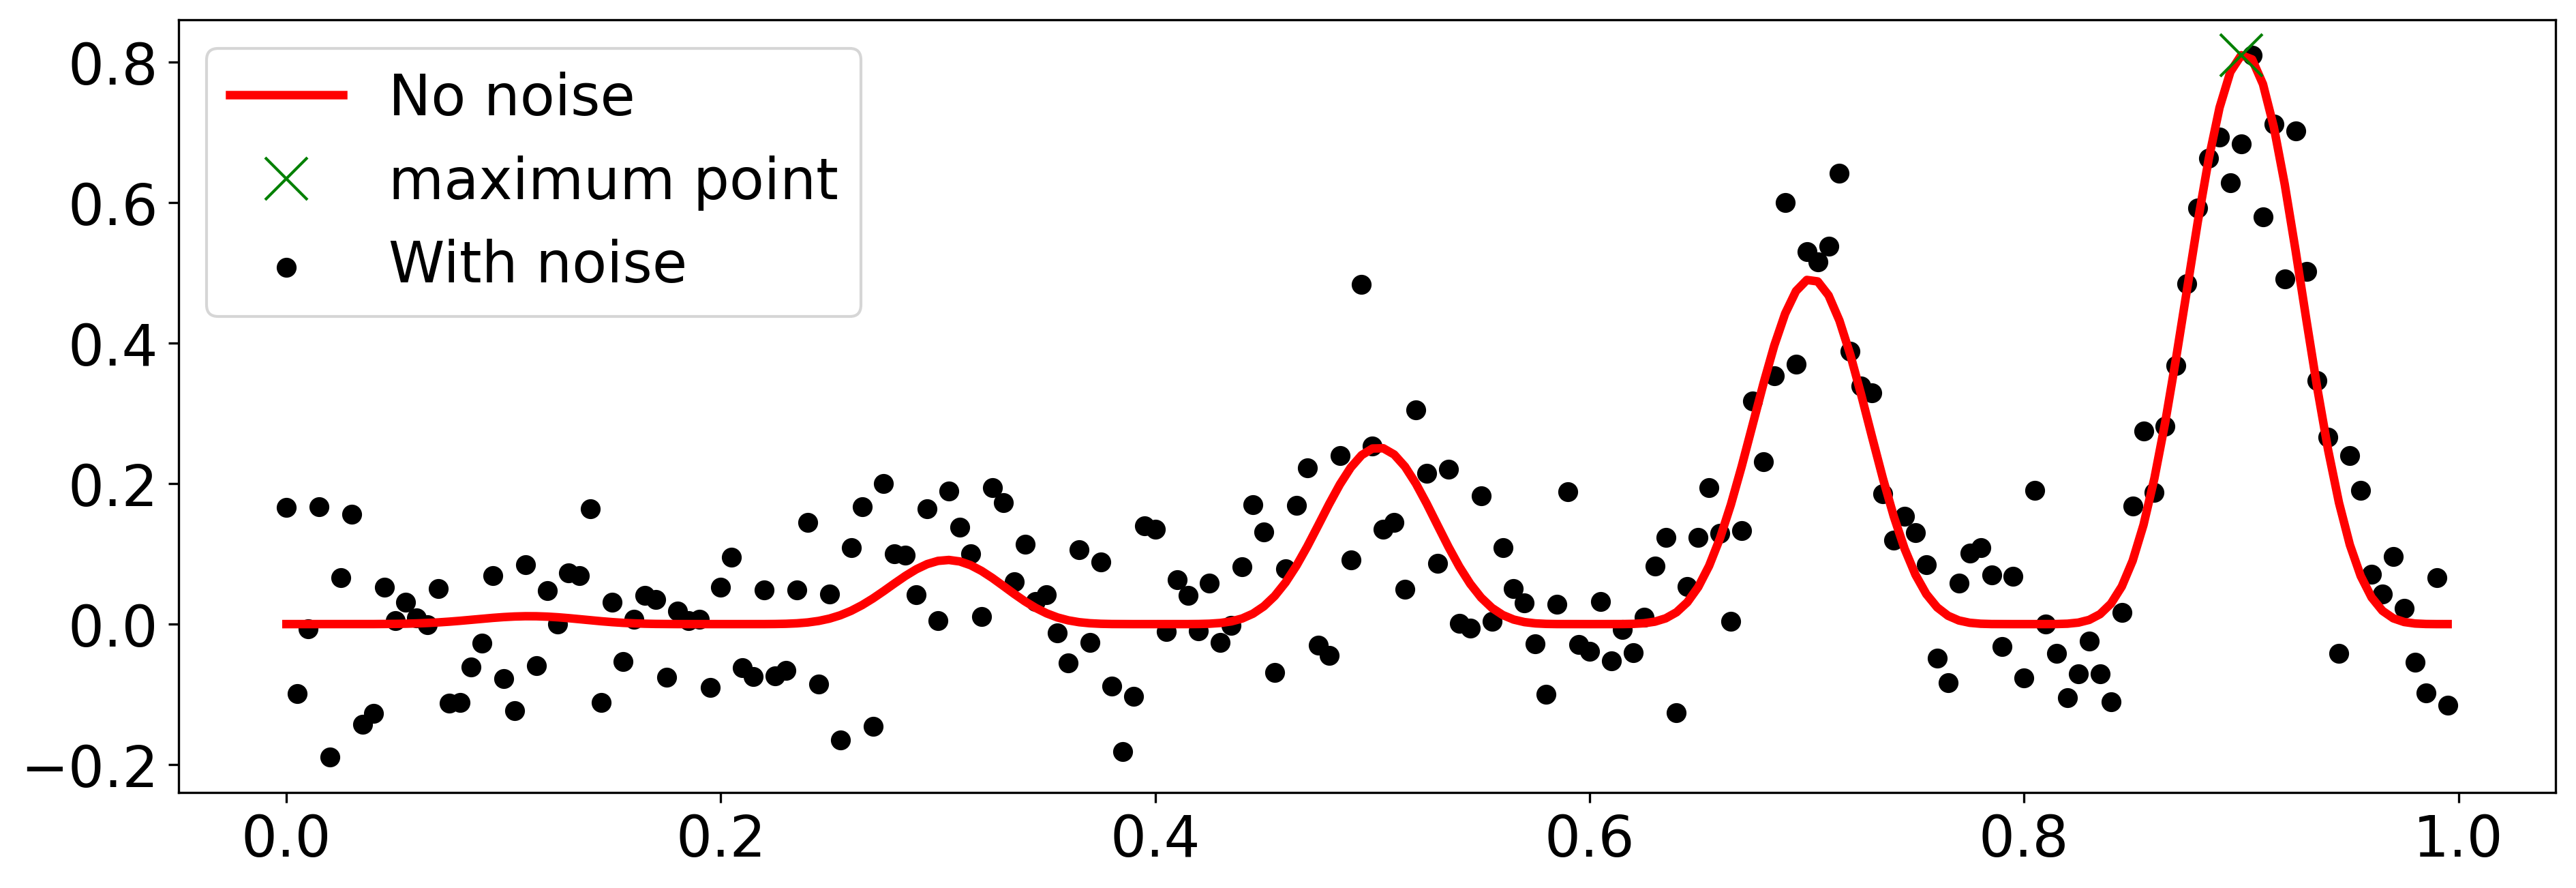

In [5]:
pyplot.scatter(X, ynoise, c = "k", label = "With noise")
pyplot.plot(X, y, "r", lw = 3, label = "No noise")
pyplot.plot(X[ix], y[ix], "xg", ms = 15, label = "maximum point")
pyplot.legend()
pyplot.show()

# Surrogate function


- The surrogate function is a technique used to best approximate the mapping of input examples to an output score.
- Probabilistically, it summarizes the conditional probability of an objective function (f), given the available data.
- This can be done via **Gaussian process** which is a model that constructs a joint probability distribution over the variables, assuming a multivariate Gaussian distribution. 
- As such, it is capable of efficient and effective summarisation of a large number of functions and **smooth transition** as more observations are made available to the model. 
- This smooth structure and smooth transition to new functions based on data are desirable properties as we sample the domain. 
- An important aspect in defining the GP model is the kernel and RBF seems to be the most used choice. 



In [6]:
def surrogate(model, X):
    """
    Returns a prediction using a surrogate model
    """
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std = True)

In [7]:
def plot(X, y, model):
    """
    Plot real observations vs surrogate function
    """
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y, label = "True data")
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, ysamplesStd = model.predict(Xsamples, return_std = True)    
    
    # Flattent the array
    up = [value[0] + ysamplesStd[i] for i, value in enumerate(ysamples)]
    low = [value[0] - ysamplesStd[i] for i, value in enumerate(ysamples)]
    Xsamples = [i[0] for i in Xsamples]

    
    pyplot.fill_between(Xsamples, low, up, alpha = 0.5,
                 label = '+/- std', color = "yellow")
    
    pyplot.plot(Xsamples, ysamples, "r", lw = 3, label = "Surrogate predictions")            
    
    pyplot.legend()
    pyplot.show()

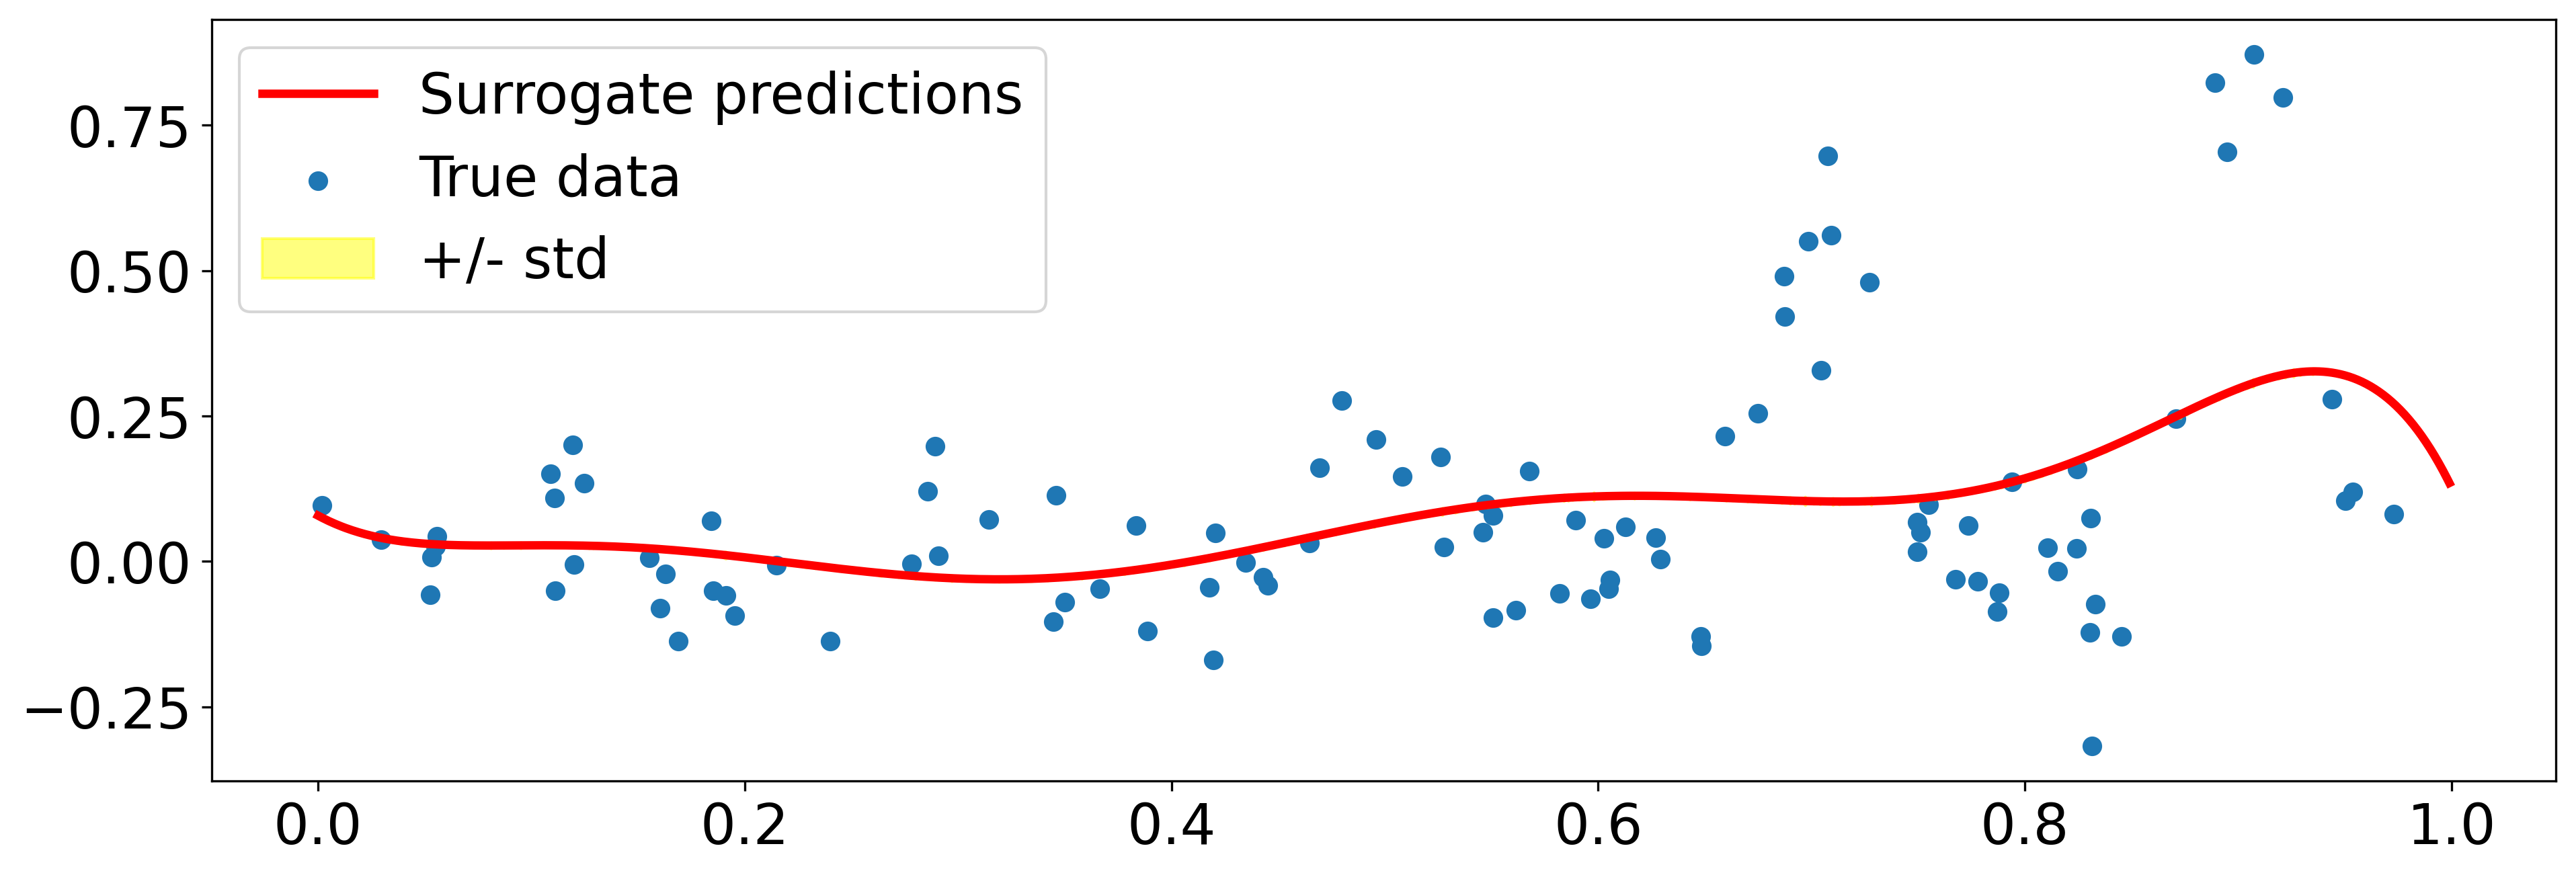

In [8]:
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)

# Acquisition funciton


- The acquisition function is responsible for scoring or estimating the likelihood that a given candidate sample (input) is worth evaluating with the real objective function. 



In [9]:
def acquisition(X, Xsamples, model):
    """Acquisition function
    
    Computes the probability of improvement acquisition function
    """
    # Get the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    
    # Get mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    
    # Get the probability of improvement
    # We are adding a small number just to avoid the division by zero
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs
 
def opt_acquisition(X, y, model):
    """
    Optimize the acquisition function
    """
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]


- Step #1 = initialose with a random sample
- Step #2 - instantiate a GP model
- Step #3 - Fit the GP model on the data (X,y) = (input, output)
- Step #4 - The algorithm then iterates for 100 cycles, selecting samples, evaluating them, and adding them to the dataset to update the surrogate function, and over again.
    - Each cycle reports the selected input value, the estimated score from the surrogate function, and the actual score. 
    - Ideally, these scores would get closer and closer as the algorithm converges on one area of the search space.




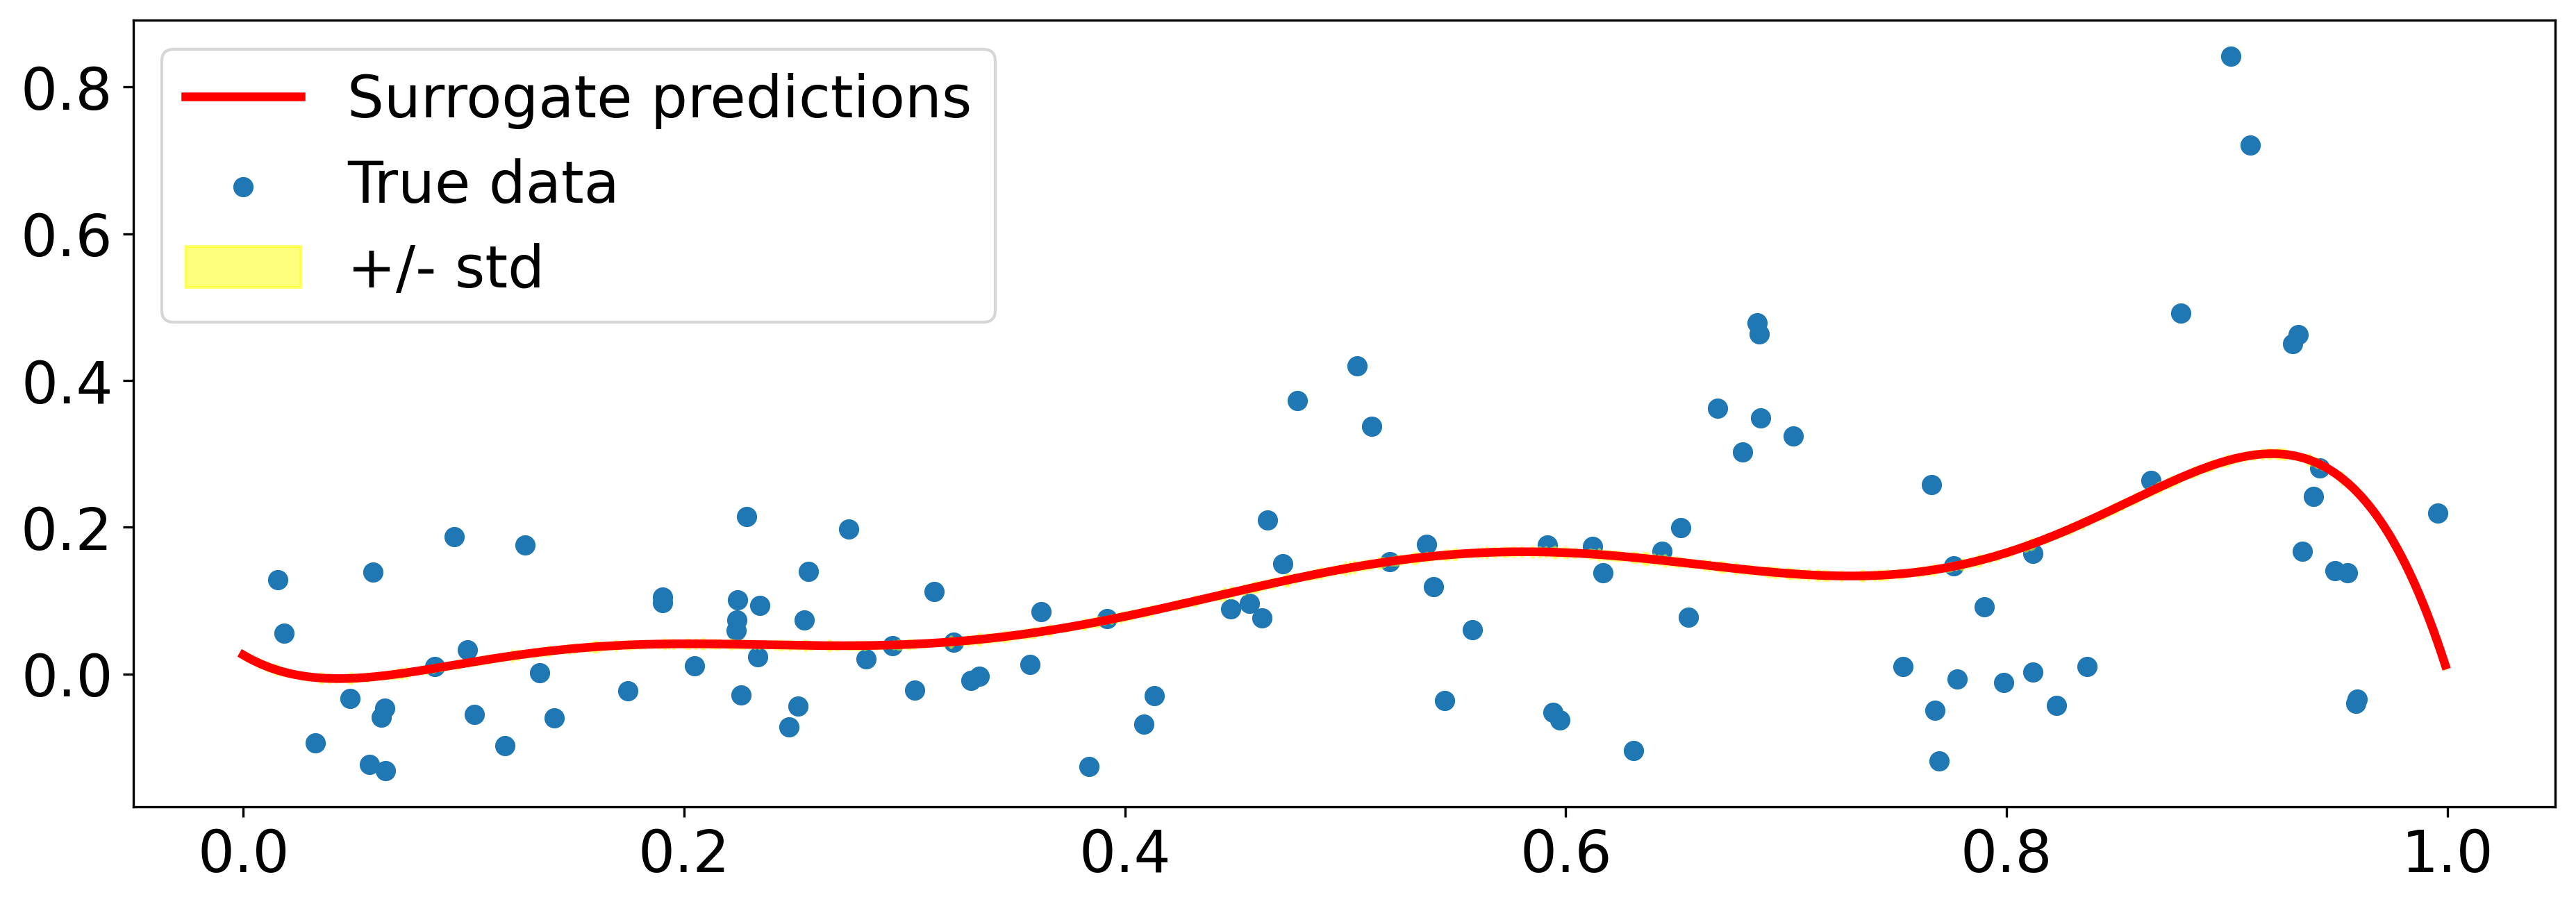

In [10]:
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y);

# This plot show the INITIALISATION points ONLY!
plot(X, y, model)

In [11]:
# Perform the optimization process for 100 loops
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>Candidate x=%.3f, estimated f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

>Candidate x=0.916, estimated f()=0.299655, actual=0.733
>Candidate x=0.920, estimated f()=0.334897, actual=0.458
>Candidate x=0.916, estimated f()=0.343828, actual=0.641
>Candidate x=0.917, estimated f()=0.364722, actual=0.738
>Candidate x=0.922, estimated f()=0.388133, actual=0.603
>Candidate x=0.919, estimated f()=0.401878, actual=0.857
>Candidate x=0.909, estimated f()=0.425395, actual=0.632
>Candidate x=0.892, estimated f()=0.417749, actual=0.759
>Candidate x=0.915, estimated f()=0.456437, actual=0.768
>Candidate x=0.921, estimated f()=0.469859, actual=0.591
>Candidate x=0.923, estimated f()=0.473659, actual=0.507
>Candidate x=0.911, estimated f()=0.478443, actual=0.842
>Candidate x=0.919, estimated f()=0.493425, actual=0.458
>Candidate x=0.891, estimated f()=0.470330, actual=0.760
>Candidate x=0.822, estimated f()=0.289614, actual=0.158
>Candidate x=0.217, estimated f()=0.034849, actual=0.011
>Candidate x=0.912, estimated f()=0.502250, actual=0.638
>Candidate x=0.513, estimated f


- This time, all 200 samples evaluated during the optimiSation task are plotted. 
- There is a **cluster of sampling** around the known optima. This is peculiar of Bayesian optimsation. By calculating the propability of sucess it concentrate the effort right where is needed.



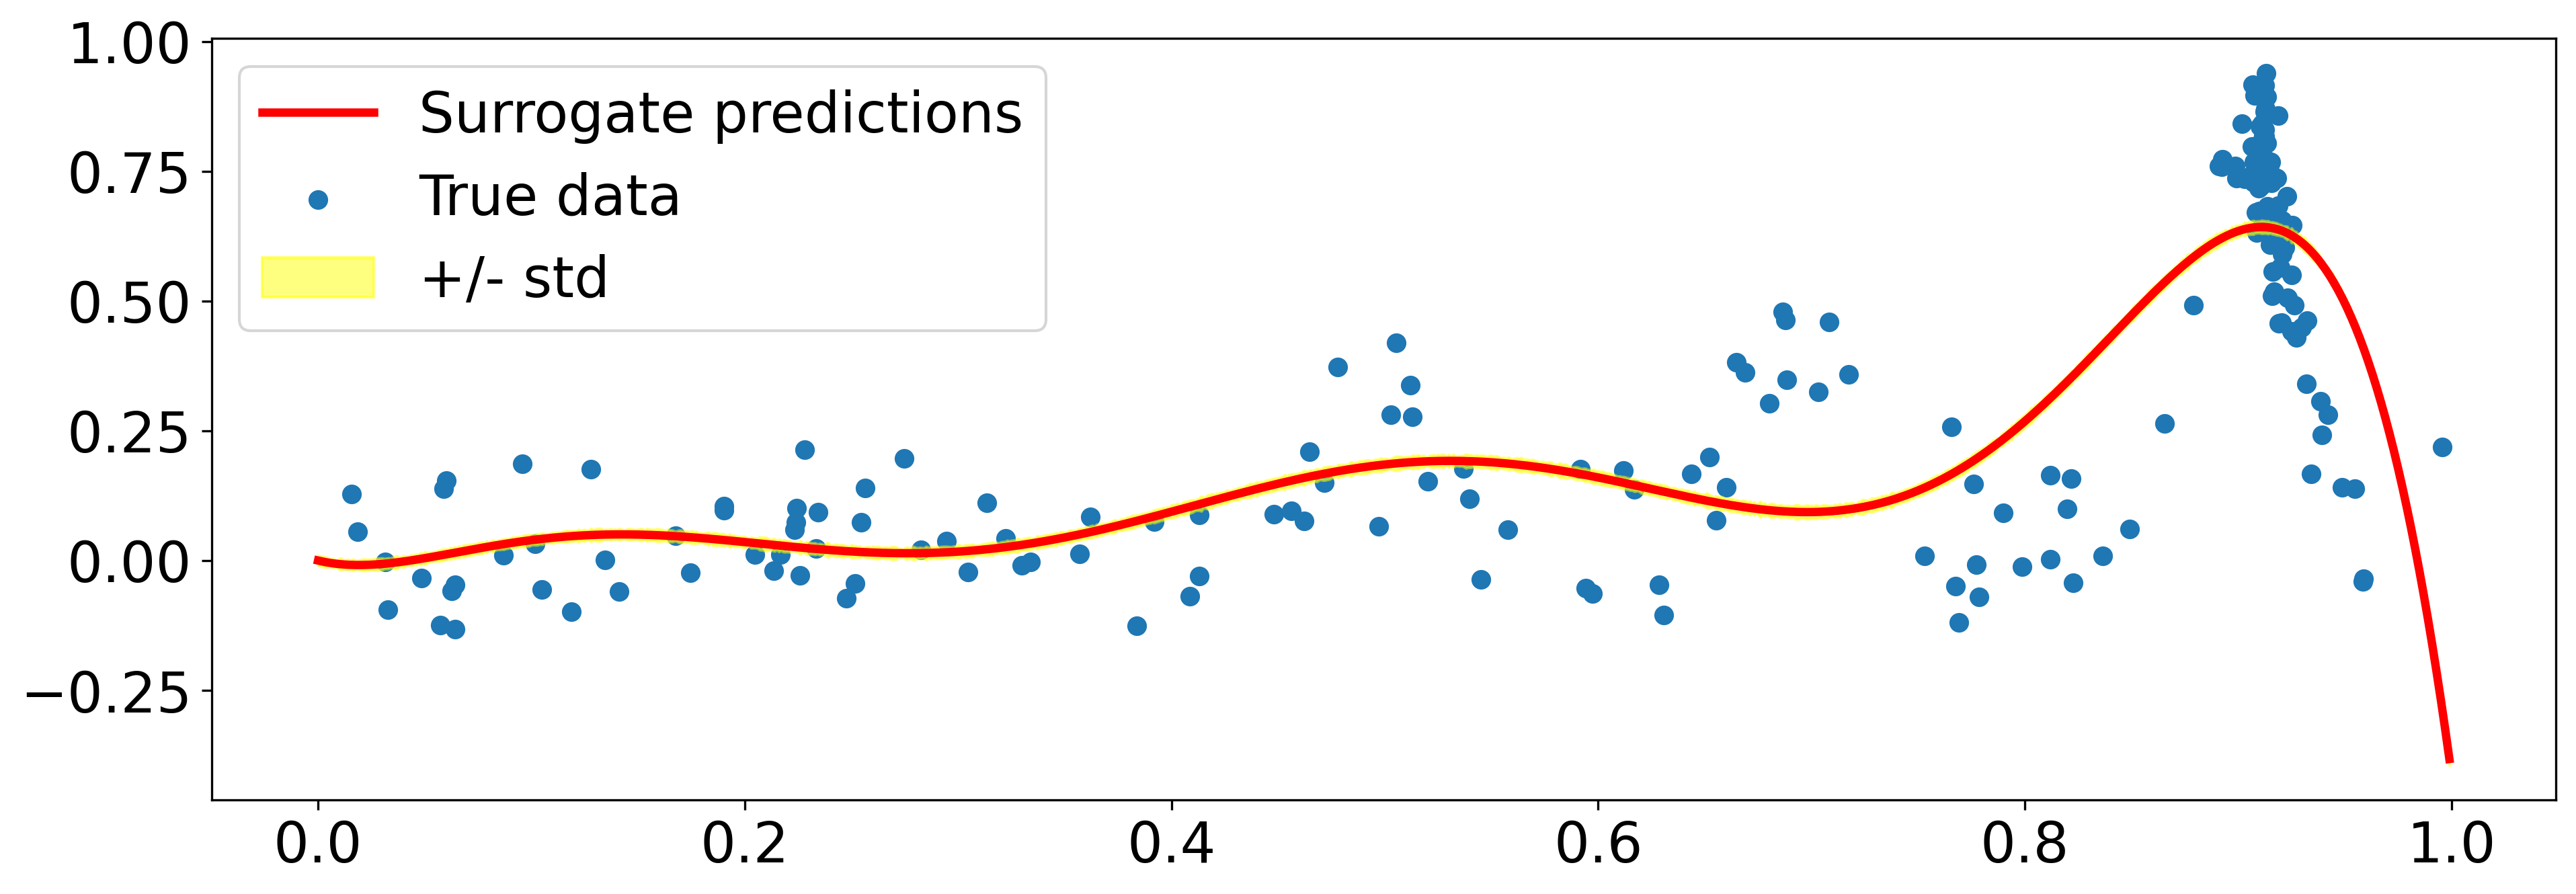

In [13]:
# plot all samples and the final surrogate function
plot(X, y, model)

In [14]:
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))
print('Optimum: x=%.3f, y=%.3f' % (X_opt, y_opt))

Best Result: x=0.913, y=0.939
Optimum: x=0.900, y=0.810



- We know the optimum has an input of 0.9 and an output of 0.810 if there was no sampling noise.
- We're getting a value close to it and this is more than acceptable given the level of noise we added to render the optimsation a bit more challenging.



# Conclusions


- In Baysian optimisation we have three functions: test, surrogate and acquisition functions.
- We use Gaussian process for the surrogate function and it is important to know its main advantage: probability estimation.
- Bayesian optimisaiton is an alternative to gradient-based and free optimsers.



# References


- https://machinelearningmastery.com/what-is-bayesian-optimization/
- https://scikit-learn.org/stable/modules/gaussian_process.html 

